# SimMod 1. Audio features
## 1. Author Documentation

- Alexander Haberl (11806899)
- Alina Godun (01569197)

### Timesheets
#### Alexander Haberl

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 15:00-16:00 | Preparation for registration assesment test |
| 2023/10/10 | 18:45-19:10 | Registration assesment test |
| 2023/10/12 | 10:00-11:00 | Pre-lecture meeting |
| 2023/10/19 | 18:00-22:00 | Watching lectures 1 and 2 |
| 2023/10/26 | 17:00-22:00 | Watching lectures 3 - 5 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/19 | 16:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 00:00-02:30 | Writing abstracts for SimMod 1 and 2 |
| 2023/12/04 | 21:00-00:00 | Setting up the repository and environment |
| 2023/12/09 | 10:00-22:00 | SimMod 1 First audio and video features for Kermit and Statler & Waldorf |
| 2023/12/09 | 10:30-20:00 | SimMod 1 First experiments, feature refinement, training classifiers, creating clean intermediate hand in file |
| 2024/01/03 | 11:00-22:00 | SimMod 1 Optical flow + features on top of optical flow |
| 2024/01/04 | 11:00-20:00 | SimMod 1 Features on top of optical flow, audio features |
| 2024/01/12 | 17:00-22:00 | SimMod 1 Hand In Notebooks |
| 2024/01/14 | 21:30-23:00 | SimMod 1 Hand In Notebooks |

#### Alina Godun

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 17:30-18:30 | Preparation for registration assesment test |
| 2023/10/10 | 19:10-19:30 | Registration assesment test |
| 2023/10/26 | 09:00-12:00 | Watching lectures 1 and 2|
| 2023/10/27 | 19:00-21:00 | Watching lecture 3|
| 2023/10/28 | 20:00-00:00 | Watching lectures 4 to 6 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/19 | 19:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 19:00-02:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/12/09 | 10:00-22:00 | SimMod 1 First audio and video features for Kermit and Statler & Waldorf |
| 2023/12/09 | 10:30-20:00 | SimMod 1 First experiments, feature refinement, training classifiers, creating clean intermediate hand in file |
| 2024/01/03 | 11:00-22:00 | SimMod 1 Train-test split, cross-validation, audio features, plots |
| 2024/01/04 | 11:00-20:00 | SimMod 1 Features on top of optical flow, audio features, plots |
| 2024/01/12 | 17:00-22:00 | SimMod 1 Hand In Notebooks |
| 2024/01/14 | 21:30-23:00 | SimMod 1 Hand In Notebooks |

## 2. Environment
To install all required libraries, create a conda environment from the conda_env.yml file:

```conda env create -f conda_env.yml```

Then activate the environment:

```conda activate SimilarityModeling```

Start jupyterlab (optional):

```jupyter lab```

## 3. Train Test Splitting

We can't randomly sample frames, because two neighboring frames are very, very similar and would lead to data leakage.
Therefore we split each episode into 2 parts of approximately equal length. Cuts were made when a new scene started, ensuring that no scene is present in both parts. This results in 6 episode partitions in total. 

We perfom nested cross-validation. 5/6 splits are used for the inner CV-loop (4/6 are used for training and 1/6 is used for validation). The outer CV-loop uses 1/6 as a testset.

The inner CV-loop is for hyperparameter tuning. All parameter combinations of the classifiers are evaluated on on each of the inner CV-folds. The hyperparameter-combination that performs the best on average is chosen for each classifier. Then each classifier is retrained on the whole 5/6 of the train-validation data with its best hyperparameters and then evaluated on the test-set. The final result is the average for each classifier over all test-folds. The best model is the one that performs the best on the outer-loop on average. 

Basically the inner-loop is for automatic hyperparameter tuning (and we don't care about the actual values of the hyperparameters), while the outer loop is for model comparison.

By doing nested cross-validation, we don't have to ensure that the test-set is representative because all frames are used for testing. If we only did holdout we would have a test-set with stronger bias, which might favor one classifier.

## 4. Feature extraction
We extract all audio features using librosa library. We use frames of length 0.4s to extract features, so for each frame, we consider the audio before and after. To ensure that no data leakage happens by audio being present in both train and test splits, we cut the episodes only between scene changes where no audio is present (for more info, see 3. Train Test Splitting).

### 4.1 Load Data

In [1]:
%load_ext autoreload
%autoreload 2

import re
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from utils import io, train, eval
from utils import feature_engineering as fe

In [2]:

videos_folder = "../data/videos"
gt_folder = "../data/gt_annotations"
temp_folder = "../data/tmp/"

episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

To compute the features from scratch set the flags to ```True```. The features are saved in the ```data/features``` directory after computation. Otherwise the precomputed features will be loaded in the next step.

In [3]:
extract_zcr = False
extract_rms = False
extract_biggest_freqs = False

### 4.2 Zero-Crossing Rate
Our first audio feature is zero crossing rate, an approximation of the fundamental frequency. This feature counts how many times audio signal crosses 0 amplitude axis within a frame. High ZCR indicates high-frequency components, while low ZCR corresponds to less dynamic sounds. 

In [4]:
if extract_zcr:
    zcr_dict = fe.get_zero_crossing_rate(video_paths, episode_names, gt_df)
    pickle.dump(zcr_dict, open("../data/features/zcr_features.pkl", "wb"))

### 4.3 Loudness (RMS)
Root Mean Square (RMS) is a feature representing the overall loudness of the audio signal within a frame. The feature is calculated by taking the root of the squared average amplitude within a frame, hence the name.

In [5]:
if extract_rms:
    rms_dict = fe.get_rms(video_paths, episode_names, gt_df)
    pickle.dump(rms_dict, open("../data/features/rms_features.pkl", "wb"))

### 4.4 Frequencies with largest magnitude
To compute our final features, we perform the FFT on each frame and then find 5 frequencies with the largest magnitudes. We use both frequencies as well as their magnitudes as features. Our consideration was that maybe the voices of different characters would have distinctive frequencies. One can argue that this belongs to SimMod 2, but unfortunately when we used only SimMod 1 features, the classification result was very bad, so we tried to improve it by incorporating slightly more complex, but still very simple features.

In [6]:
if extract_biggest_freqs:
    biggest_freqs_dict = fe.get_biggest_freqs(video_paths, episode_names, gt_df)
    pickle.dump(biggest_freqs_dict, open("../data/features/biggest_freqs_features.pkl", "wb"))

## 5. Classification

### 5.1 Load features

The (pre-)computed features are loaded from the ```data/features``` directory.

In [7]:
final_df = gt_df.copy()

In [8]:
zcr_feat_dict = pickle.load(open("../data/features/zcr_features.pkl", "rb"))

for ep in episode_names:
    final_df.loc[final_df['episode'] == ep, 'zcr'] = zcr_feat_dict[ep]

In [9]:
rms_feat_dict = pickle.load(open("../data/features/rms_features.pkl", "rb"))

for ep in episode_names:
    final_df.loc[final_df['episode'] == ep, 'rms'] = rms_feat_dict[ep]

In [10]:
biggest_freqs_feat_dict = pickle.load(open(f"../data/features/biggest_freqs_features.pkl", "rb"))

for ep in episode_names:
    current_ep_feats = biggest_freqs_feat_dict[ep]
    for feat_name, feat in current_ep_feats.items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feat

### 5.2 Run experiments
On our machines, the training takes approx. 8 mins for each class, or approx. 16 minutes in total. If you want to retrain a classifier and generate new evaluation data, set ```train_models``` param to ```True``` (make sure that ```save_results``` is also set to ```True```, so that evaluation data is saved). Important! Each classification target (Kermit/Statler&Waldorf) has it's own parameters, if you want to retrain both, change parameters in both places.

For our experiments, we decided to use:
- RandomForest (ensemble, separator)
- DecisionTree (separator) 
- KNN (hedger) 

classifiers to cover wide range of different types of classifiers.  

#### 5.2.1 Kermit

In [11]:
train_models = False
save_results = True
feat_type = 'audio'
target_col = 'Kermit'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'rms' in c
              or 'zcr' in c
              or 'freq' in c
              or 'biggest_mag' in c]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training: \n- {train_cols_str}")

Columns used for training: 
- zcr
- rms
- freq_0
- biggest_mag_0
- freq_1
- biggest_mag_1
- freq_2
- biggest_mag_2
- freq_3
- biggest_mag_3
- freq_4
- biggest_mag_4


In [12]:
clf_config = [
    {
        'model_name': 'RandomForest',	
        'model': RandomForestClassifier(),
        'param_grid': {
            'clf__n_estimators': [10, 50],
            'clf__max_depth': [10, 50]
        },
    },
    {
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'clf__max_depth': [10, 50]
        },
    },
    {
        'model_name': 'KNN',
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [1, 3, 10]
        },
    }
]

In [13]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv(final_df, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type)

#### 5.2.2 Statler & Waldorf

In [14]:
train_models = False
save_results = True
feat_type = 'audio'
target_col = 'Audio_StatlerWaldorf'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'rms' in c
              or 'zcr' in c
              or 'freq' in c
              or 'biggest_mag' in c]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training: \n- {train_cols_str}")

Columns used for training: 
- zcr
- rms
- freq_0
- biggest_mag_0
- freq_1
- biggest_mag_1
- freq_2
- biggest_mag_2
- freq_3
- biggest_mag_3
- freq_4
- biggest_mag_4


In [15]:
clf_config = [
    {
        'model_name': 'RandomForest',	
        'model': RandomForestClassifier(),
        'param_grid': {
            'clf__n_estimators': [10, 50],
            'clf__max_depth': [10, 50]
        },
    },
    {
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'clf__max_depth': [10, 50]
        },
    },
    {
        'model_name': 'KNN',
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [1, 3, 10]
        },
    }
]

In [16]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv(final_df, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type)

## 6. Results & Discussion

#### 6.1 Kermit

In [17]:
target_col = 'Kermit'
eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))

In [18]:
precision_dict, recall_dict, f1_dict, fpr_dict, tpr_dict = eval.get_eval_info(eval_df, clf_dict_outer)

The following curves provide infomation about precision, recall, TPR and FPR for all experiment runs and parameter combinations, both from inner and outer CV loops.

As we can see from the following curves, the extracted audio features do not provide enough information for the classification. As can be seen from the ROC curve, the classifier is not random, and has a higher TPR then FPR as a rule then a random classifier would have, but the performance is still pretty bad.

There is little difference in performance across classifiers, which indicates that the features are most likely not informative enough.

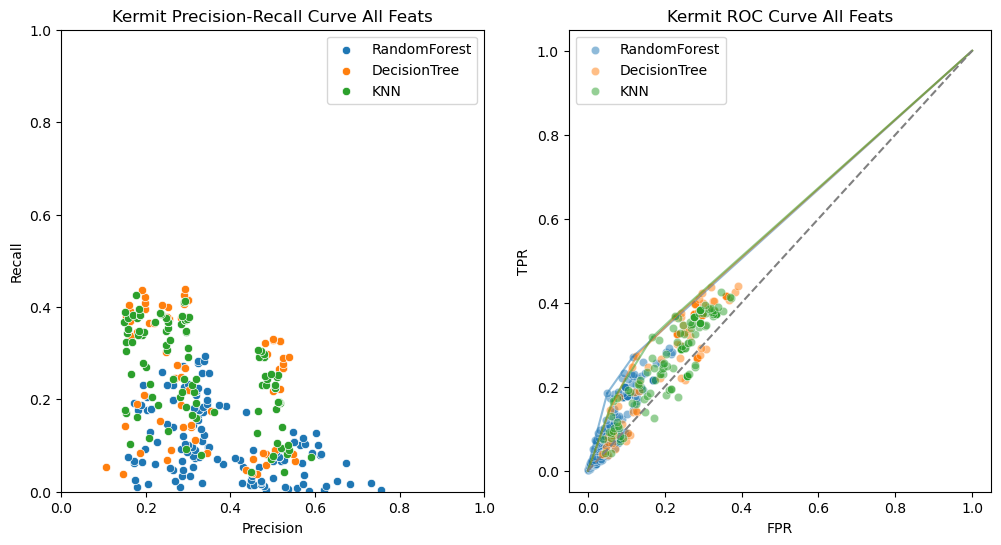

In [19]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
eval.plot_precision_recall_curve(precision_dict, recall_dict, model_names=clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats', ax=axes[0], plot_curve=False)
eval.plot_roc_curve(fpr_dict, tpr_dict, model_names=clf_dict_outer.keys(), title=f'{target_col} ROC Curve All Feats', ax=axes[1])

The following curves provide the information about TPR and FPR at different classification thresholds for the best hyperparameter combinations of each model. It also shows that the classification result is close to random.

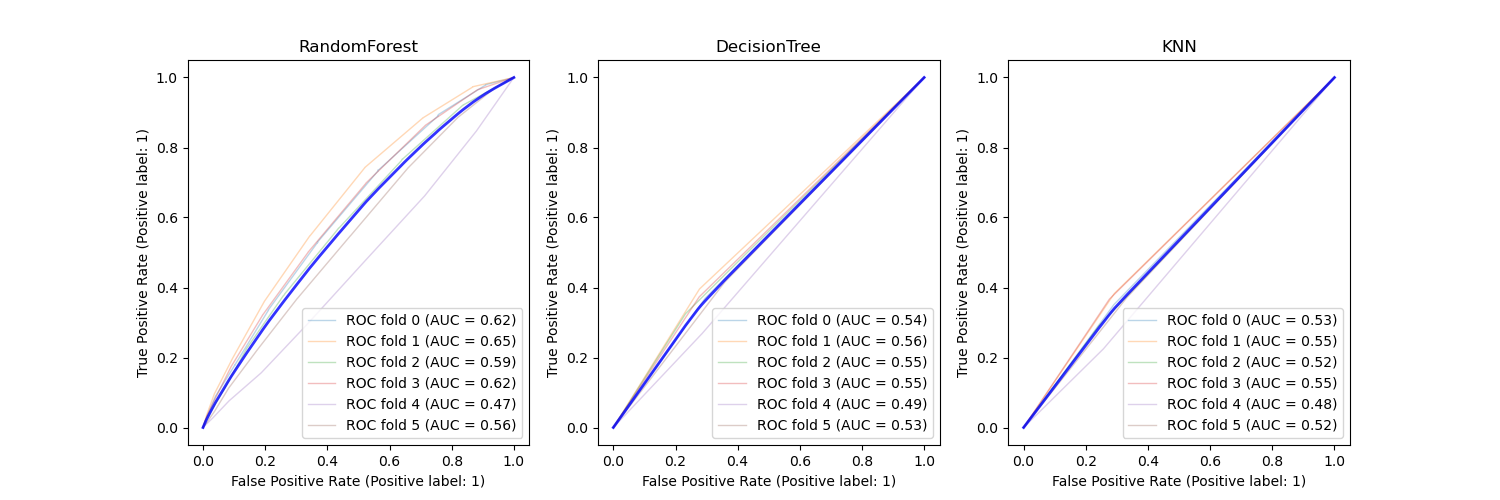

In [20]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_{feat_type}_precision_recall.png"
display(Image(filename=filename))

As we can see, there is little difference in feature importance according to the Random Forest, but this can also be explained by the fact that some features are strongly intercorrelated:

[Text(0.5, 1.0, 'Kermit Feature importance (from RandomForest)')]

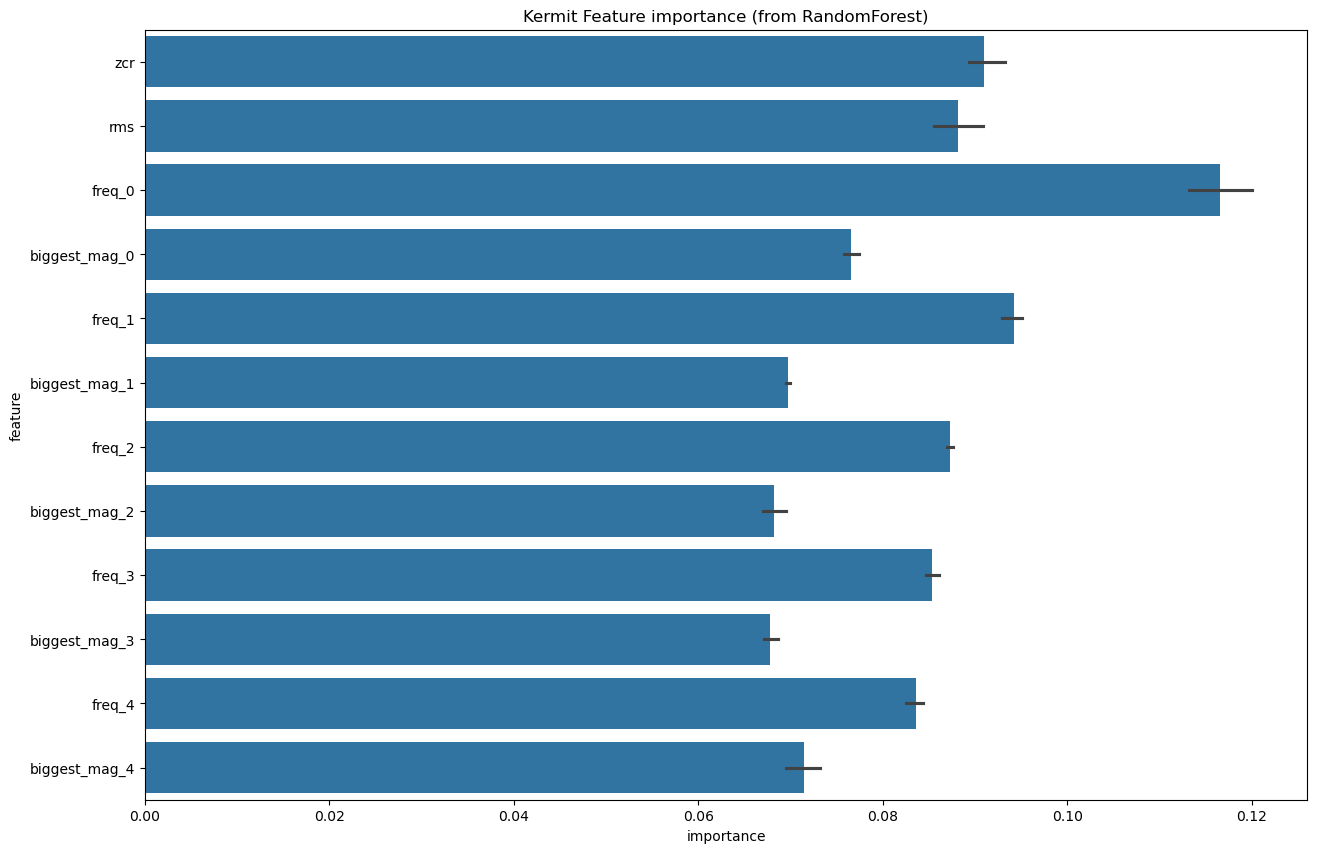

In [21]:
feature_importance_df = eval.get_feature_importance_rf(train_cols, clf_dict_outer)

_, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=feature_importance_df, y='feature', x='importance')
ax.set(title=f'{target_col} Feature importance (from RandomForest)')

Text(0.5, 1.0, 'Feature intercorrelation')

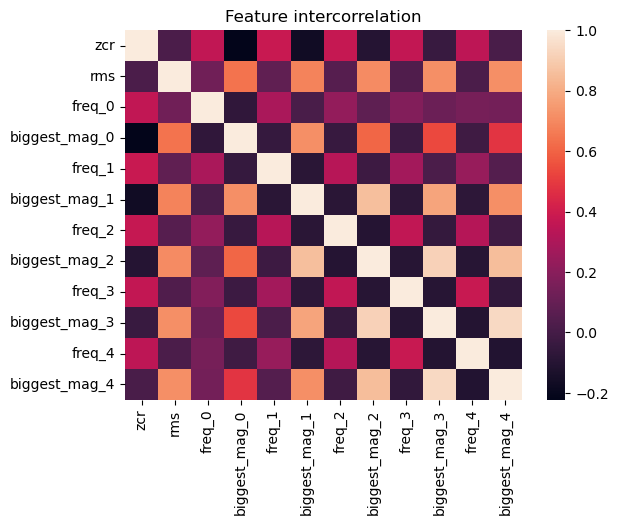

In [22]:
ax = sns.heatmap(final_df[train_cols].corr())
ax.set_title('Feature intercorrelation')

#### 6.2 Statler & Waldorf

In [23]:
target_col = 'Audio_StatlerWaldorf'
eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))

In [24]:
precision_dict, recall_dict, f1_dict, fpr_dict, tpr_dict = eval.get_eval_info(eval_df, clf_dict_outer)

In comparison to Kermit, the performance of the classifier for Statler and Waldorf is even worse. The TPR is much lower in comparison to the TPR of Kermit, but we can see that the classifier also has much lower FPR: it stays very close to 0 at all times.

KNN classifier performs slightly better then other classifiers, but the difference is negligible:

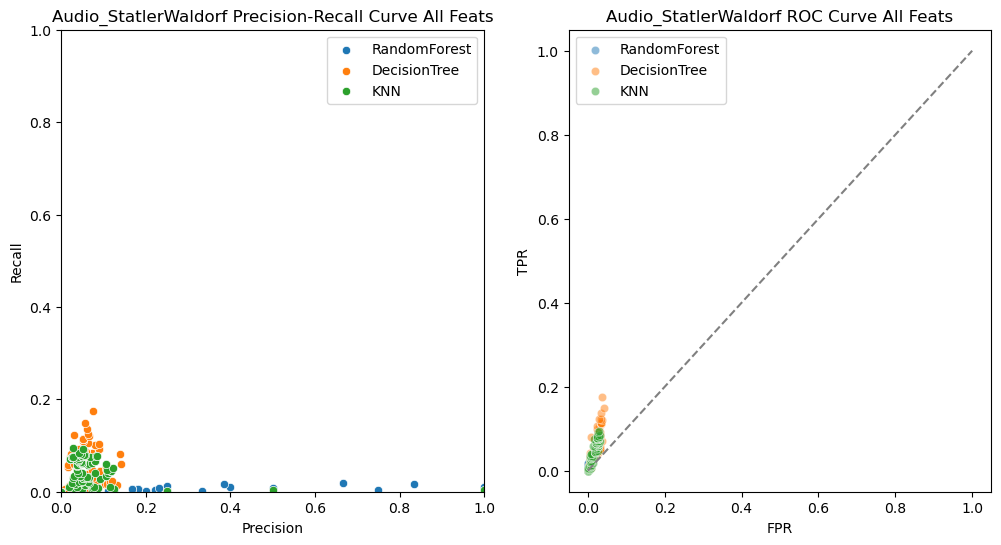

In [25]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
eval.plot_precision_recall_curve(precision_dict, recall_dict, clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats', ax=axes[0], plot_curve=False)
eval.plot_roc_curve(fpr_dict, tpr_dict, clf_dict_outer.keys(), title=f'{target_col} ROC Curve All Feats', ax=axes[1], plot_curve=False)


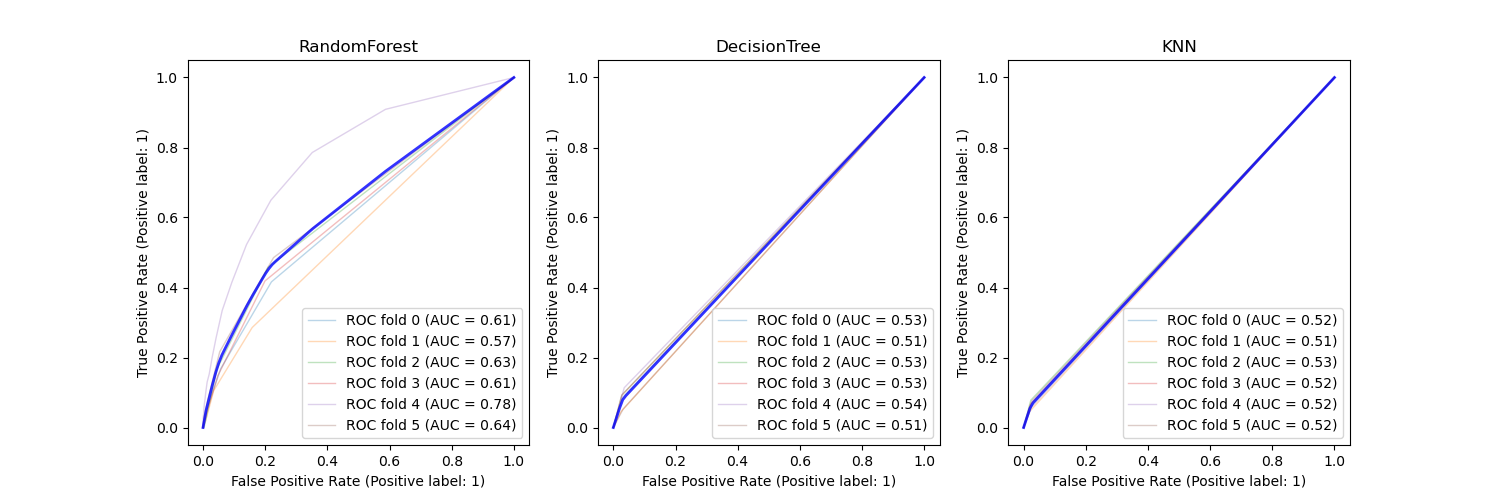

In [26]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_{feat_type}_precision_recall.png"
display(Image(filename=filename))

Again, there is little difference in the feature importances provided by RandomForest classifier:

[Text(0.5, 1.0, 'Audio_StatlerWaldorf Feature importance (from RandomForest)')]

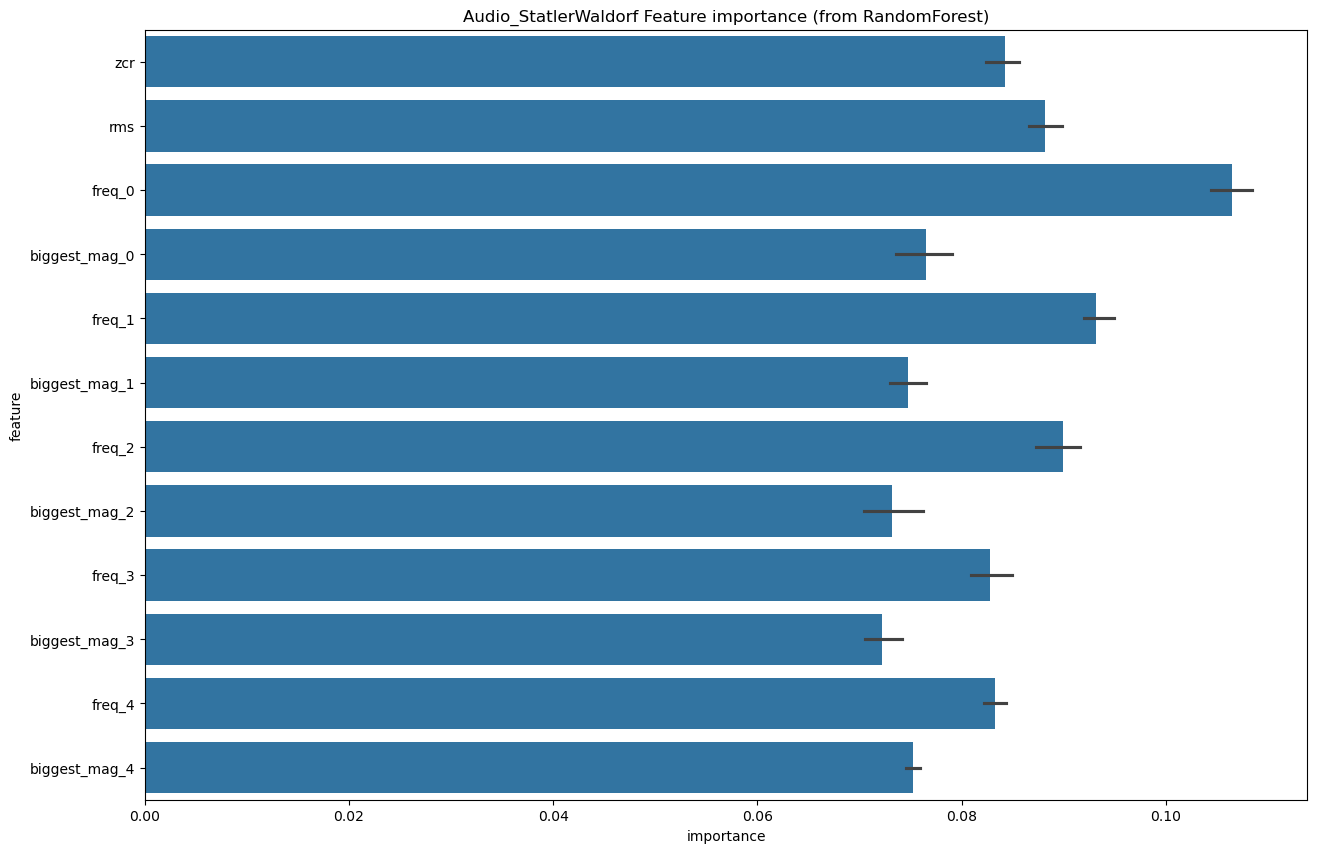

In [27]:
feature_importance_df = eval.get_feature_importance_rf(train_cols, clf_dict_outer)

_, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=feature_importance_df, y='feature', x='importance')
ax.set(title=f'{target_col} Feature importance (from RandomForest)')

## 7. Conclusion


As we have seen based on the performance metrics and visualizations, the simple audio features presented in SimMod 1 were not enough to build a good character classifier on its own. The features cannot capture the complexity of human speech sufficiently.